# Final Project - Reinforcements Learning - Ex1

---

<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

Full Notebook:
### https://colab.research.google.com/drive/1umfxWIoivhACC9YcWRZIxINsZch9JEaC?usp=sharing

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!pip install stable-baselines3[extra]
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip
!git clone https://github.com/daniel-litebc/Intro_to_Reinforcement-Learning-Final_Submission.git


# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque
import torch.nn.functional as F
from itertools import count
from stable_baselines3 import PPO
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [ ]:
assert torch.cuda.is_available()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [ ]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Function - given an environment it will return the indexes position and boxes locations

In [ ]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

## EX2- FIX SCENARIO -  PUSH & PULL - ONE BOX

In [ ]:
#=============== DO NOT DELETE ===============
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

#Utils

In [ ]:
def conv2d_size_out(size, kernel_size=5, stride=2):
    return (size - (kernel_size - 1) - 1) // stride + 1

h, w, c = sok.observation_space.shape

def save_checkpoint(filename, policy_model):
    checkpoint = {
        'policy_model_state_dict': policy_model.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(filename, policy_model, target_model):
    checkpoint = torch.load(filename)
    policy_model.load_state_dict(checkpoint['policy_model_state_dict'])
    target_model.load_state_dict(policy_model.state_dict())
    target_model.eval()


def plot_model_performance(mean_rewards, mean_lengths):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(mean_rewards)
  plt.title('Mean Episodic Reward')
  plt.xlabel('Episode')
  plt.ylabel('Mean Reward')

  plt.subplot(1, 2, 2)
  plt.plot(mean_lengths)
  plt.title('Mean Episodic Length')
  plt.xlabel('Episode')
  plt.ylabel('Mean Length')

  plt.show()

#DQN Model

In [ ]:
# Calculate the dimensions after passing through all the convolutional layers
convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
linear_input_size = convw * convh * 32  # 32 is the output channel size of the last conv layer

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

#Experience Replay

In [ ]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward', 'done'))
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Experience(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

#Utils Training

In [ ]:
def reward_shaping(current_room_state, next_room_state, distances_to_target):

  # If there is no change in the room state we are
  if np.array_equal(current_room_state, next_room_state): return -0.1

  current_box_position, current_monster_position = get_positions(current_room_state, distances_to_target)
  next_box_position, next_monster_position = get_positions(next_room_state, distances_to_target)

  # Calculate distances
  current_b2m = get_box_to_monster_distance(current_box_position, current_monster_position)
  next_b2m = get_box_to_monster_distance(next_box_position, next_monster_position)
  current_b2t = get_box_to_target_distance(current_box_position, distances_to_target)
  next_b2t = get_box_to_target_distance(next_box_position, distances_to_target)

  # Reward agent based on if box moved closer to target
  reward_b2t = 0.5 if next_b2t < current_b2t else (-0.5 if next_b2t > current_b2t else 0.0)

  # Reward agent based on if agent moved closer to box
  reward_b2m = 0.1 if next_b2m < current_b2m else (-0.1 if next_b2m > current_b2m else 0.0)

  return reward_b2t + reward_b2m


def get_positions(room_state, distances):
  box_position = tuple(np.argwhere(room_state == 4).ravel())
  monster_position = tuple(np.argwhere(room_state == 5).ravel())

  return box_position, monster_position


def get_box_to_monster_distance(box_position, monster_position):
  return np.sum((np.array(monster_position) - np.array(box_position))**2)


def get_box_to_target_distance(box_position, distances_to_target):
  return distances_to_target[box_position]


def get_distances(room_state):
  target = np.where(room_state == 2)
  if target[0].size == 0:
      return None

  target = (target[0][0], target[1][0])
  distances = np.full_like(room_state, -1, dtype=int)
  distances[target] = 0

  visited_cells = {target}
  cell_queue = deque([target])

  directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

  while cell_queue:
      cell_x, cell_y = cell_queue.popleft()
      distance = distances[cell_x][cell_y]

      for dx, dy in directions:
          next_cell_x, next_cell_y = cell_x + dx, cell_y + dy

          if (0 <= next_cell_x < room_state.shape[0]
                  and 0 <= next_cell_y < room_state.shape[1]
                  and room_state[next_cell_x][next_cell_y] != 0
                  and (next_cell_x, next_cell_y) not in visited_cells):
              distances[next_cell_x][next_cell_y] = distance + 1
              visited_cells.add((next_cell_x, next_cell_y))
              cell_queue.append((next_cell_x, next_cell_y))

  return distances

#Training

In [ ]:
# Hyperparameters
BATCH_SIZE = 256
GAMMA = 0.95       #was 0.999
EPS_START = 1.0    # was 0.9
EPS_END = 0.1      # was 0.05
EPS_DECAY = 20000  #was 10,000
TARGET_UPDATE = 5

# Bad way to update epsilon
steps_done = 0

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the DQN and target network
n_actions = sok.action_space.n
policy_net = DQN(h, w, n_actions).to(device)
target_net = DQN(h, w, n_actions).to(device)
optimizer = optim.RMSprop(policy_net.parameters(), lr=0.001)
memory = ReplayMemory(10000)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Experience(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [ ]:
def train_loop(policy_net, target_net, optimizer, memory, max_steps_per_episode=500, num_episodes=100):

  total_rewards = 0
  total_lengths = 0
  mean_rewards = []
  mean_lengths = []

  for i_episode in tqdm(range(num_episodes)):

    episode_reward = 0.0


    state_array = sok.reset()
    state = torch.tensor(state_array.transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)


    distances = get_distances(sok.room_state)
    current_room_state = sok.room_state.copy()

    # Save once every 10 episodes
    if (i_episode + 1) % 10 == 0:
      save_checkpoint("DQN-checkpoint-v2-ep" + str(i_episode), policy_net)

    for t in range(max_steps_per_episode):
      action = select_action(state)
      next_state, reward, done, _ = sok.step(action.item())

      next_room_state = sok.room_state.copy()

      if not done:
        reward += reward_shaping(current_room_state, next_room_state, distances)

      current_room_state = next_room_state.copy()


      episode_reward += reward

      next_state = torch.tensor(next_state.transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)
      reward = torch.tensor([reward], device=device)
      memory.push(state, action, next_state, reward, done)
      state = next_state

      optimize_model()
      if done:
          break

    total_rewards += episode_reward
    total_lengths += t + 1

    mean_episodic_reward = total_rewards / (i_episode + 1)
    mean_episodic_length = total_lengths / (i_episode + 1)

    mean_rewards.append(mean_episodic_reward)
    mean_lengths.append(mean_episodic_length)

    print()
    print("=" * 20 + "Training Progress " + "Episode " + str(i_episode + 1) + "=" * 20)
    print("Mean Episode Reward: ", mean_episodic_reward)
    print("Mean Episode Length: ", mean_episodic_length)
    print(f"Current Episode Reward: {episode_reward}")
    print(f"Current Episode Length: {t + 1}")

    print()



    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

  return mean_rewards, mean_lengths

# Train Model

In [ ]:
mean_rewards, mean_lengths = train_loop(policy_net, target_net, optimizer, memory, max_steps_per_episode=500, num_episodes=300)

  0%|          | 1/300 [00:09<45:17,  9.09s/it]


====================Training Progress Episode 1====================
Mean Episode Reward:  -808.0000000000069
Mean Episode Length:  500.0
Current Episode Reward: -808.0000000000069
Current Episode Length: 500



  1%|          | 2/300 [00:26<1:08:45, 13.84s/it]


====================Training Progress Episode 2====================
Mean Episode Reward:  -994.5000000000036
Mean Episode Length:  500.0
Current Episode Reward: -1181.0000000000005
Current Episode Length: 500



  1%|          | 3/300 [00:44<1:17:29, 15.65s/it]


====================Training Progress Episode 3====================
Mean Episode Reward:  -990.6666666666719
Mean Episode Length:  500.0
Current Episode Reward: -983.000000000008
Current Episode Length: 500



  1%|▏         | 4/300 [01:01<1:20:02, 16.22s/it]


====================Training Progress Episode 4====================
Mean Episode Reward:  -976.2500000000059
Mean Episode Length:  500.0
Current Episode Reward: -933.0000000000084
Current Episode Length: 500



  2%|▏         | 5/300 [01:18<1:21:05, 16.49s/it]


====================Training Progress Episode 5====================
Mean Episode Reward:  -912.800000000006
Mean Episode Length:  500.0
Current Episode Reward: -659.0000000000067
Current Episode Length: 500



  2%|▏         | 6/300 [01:19<55:22, 11.30s/it]  


====================Training Progress Episode 6====================
Mean Episode Reward:  -777.750000000005
Mean Episode Length:  422.5
Current Episode Reward: -102.49999999999993
Current Episode Length: 35



  2%|▏         | 7/300 [01:36<1:04:12, 13.15s/it]


====================Training Progress Episode 7====================
Mean Episode Reward:  -817.2142857142909
Mean Episode Length:  433.57142857142856
Current Episode Reward: -1054.0000000000068
Current Episode Length: 500



  3%|▎         | 8/300 [01:53<1:10:01, 14.39s/it]


====================Training Progress Episode 8====================
Mean Episode Reward:  -809.8125000000055
Mean Episode Length:  441.875
Current Episode Reward: -758.0000000000077
Current Episode Length: 500



  3%|▎         | 9/300 [02:10<1:13:59, 15.26s/it]


====================Training Progress Episode 9====================
Mean Episode Reward:  -818.7222222222279
Mean Episode Length:  448.3333333333333
Current Episode Reward: -890.0000000000077
Current Episode Length: 500



  3%|▎         | 10/300 [02:14<57:09, 11.83s/it] 


====================Training Progress Episode 10====================
Mean Episode Reward:  -762.470000000005
Mean Episode Length:  415.7
Current Episode Reward: -256.1999999999997
Current Episode Length: 122



  4%|▎         | 11/300 [02:31<1:04:42, 13.43s/it]


====================Training Progress Episode 11====================
Mean Episode Reward:  -799.2454545454592
Mean Episode Length:  423.3636363636364
Current Episode Reward: -1167.0000000000002
Current Episode Length: 500



  4%|▍         | 12/300 [02:48<1:09:51, 14.55s/it]


====================Training Progress Episode 12====================
Mean Episode Reward:  -801.4750000000049
Mean Episode Length:  429.75
Current Episode Reward: -826.0000000000073
Current Episode Length: 500



  4%|▍         | 13/300 [02:49<49:54, 10.43s/it]  


====================Training Progress Episode 13====================
Mean Episode Reward:  -744.9615384615429
Mean Episode Length:  398.84615384615387
Current Episode Reward: -66.8
Current Episode Length: 28



  5%|▍         | 14/300 [02:51<36:51,  7.73s/it]


====================Training Progress Episode 14====================
Mean Episode Reward:  -697.3500000000041
Mean Episode Length:  373.5
Current Episode Reward: -78.39999999999998
Current Episode Length: 44



  5%|▌         | 15/300 [03:08<50:08, 10.55s/it]


====================Training Progress Episode 15====================
Mean Episode Reward:  -720.2600000000043
Mean Episode Length:  381.93333333333334
Current Episode Reward: -1041.0000000000066
Current Episode Length: 500



  5%|▌         | 16/300 [03:25<59:58, 12.67s/it]


====================Training Progress Episode 16====================
Mean Episode Reward:  -738.8062500000046
Mean Episode Length:  389.3125
Current Episode Reward: -1017.0000000000088
Current Episode Length: 500



  6%|▌         | 17/300 [03:26<42:54,  9.10s/it]


====================Training Progress Episode 17====================
Mean Episode Reward:  -701.3058823529454
Mean Episode Length:  367.7647058823529
Current Episode Reward: -101.29999999999995
Current Episode Length: 23



  6%|▌         | 18/300 [03:32<38:07,  8.11s/it]


====================Training Progress Episode 18====================
Mean Episode Reward:  -688.6833333333375
Mean Episode Length:  356.8333333333333
Current Episode Reward: -474.10000000000224
Current Episode Length: 171



  6%|▋         | 19/300 [03:49<50:46, 10.84s/it]


====================Training Progress Episode 19====================
Mean Episode Reward:  -698.0157894736885
Mean Episode Length:  364.36842105263156
Current Episode Reward: -866.0000000000073
Current Episode Length: 500



  7%|▋         | 20/300 [04:06<59:24, 12.73s/it]


====================Training Progress Episode 20====================
Mean Episode Reward:  -687.7150000000045
Mean Episode Length:  371.15
Current Episode Reward: -492.0000000000047
Current Episode Length: 500



  7%|▋         | 21/300 [04:24<1:05:16, 14.04s/it]


====================Training Progress Episode 21====================
Mean Episode Reward:  -696.1571428571475
Mean Episode Length:  377.2857142857143
Current Episode Reward: -865.0000000000083
Current Episode Length: 500



  7%|▋         | 22/300 [04:24<46:21, 10.01s/it]  


====================Training Progress Episode 22====================
Mean Episode Reward:  -665.0000000000044
Mean Episode Length:  360.90909090909093
Current Episode Reward: -10.700000000000001
Current Episode Length: 17



  8%|▊         | 23/300 [04:39<53:08, 11.51s/it]


====================Training Progress Episode 23====================
Mean Episode Reward:  -662.6739130434828
Mean Episode Length:  364.1304347826087
Current Episode Reward: -611.5000000000048
Current Episode Length: 435



  8%|▊         | 24/300 [04:40<38:40,  8.41s/it]


====================Training Progress Episode 24====================
Mean Episode Reward:  -637.954166666671
Mean Episode Length:  350.375
Current Episode Reward: -69.39999999999995
Current Episode Length: 34



  8%|▊         | 25/300 [04:43<30:46,  6.71s/it]


====================Training Progress Episode 25====================
Mean Episode Reward:  -616.6800000000042
Mean Episode Length:  339.6
Current Episode Reward: -106.0999999999998
Current Episode Length: 81



  9%|▊         | 26/300 [04:43<21:53,  4.79s/it]


====================Training Progress Episode 26====================
Mean Episode Reward:  -592.9576923076963
Mean Episode Length:  326.88461538461536
Current Episode Reward: 0.1000000000000032
Current Episode Length: 9



  9%|▉         | 27/300 [05:01<38:44,  8.51s/it]


====================Training Progress Episode 27====================
Mean Episode Reward:  -596.0703703703743
Mean Episode Length:  333.2962962962963
Current Episode Reward: -677.0000000000059
Current Episode Length: 500



  9%|▉         | 28/300 [05:18<50:34, 11.16s/it]


====================Training Progress Episode 28====================
Mean Episode Reward:  -595.2464285714326
Mean Episode Length:  339.25
Current Episode Reward: -573.0000000000059
Current Episode Length: 500



 10%|▉         | 29/300 [05:35<58:36, 12.97s/it]


====================Training Progress Episode 29====================
Mean Episode Reward:  -609.4448275862111
Mean Episode Length:  344.7931034482759
Current Episode Reward: -1007.0000000000075
Current Episode Length: 500



 10%|█         | 30/300 [05:36<42:35,  9.46s/it]


====================Training Progress Episode 30====================
Mean Episode Reward:  -590.5533333333374
Mean Episode Length:  334.53333333333336
Current Episode Reward: -42.700000000000024
Current Episode Length: 37



 10%|█         | 31/300 [05:37<31:07,  6.94s/it]


====================Training Progress Episode 31====================
Mean Episode Reward:  -572.5387096774233
Mean Episode Length:  324.741935483871
Current Episode Reward: -32.10000000000001
Current Episode Length: 31



 11%|█         | 32/300 [05:38<22:56,  5.14s/it]


====================Training Progress Episode 32====================
Mean Episode Reward:  -558.4500000000038
Mean Episode Length:  315.4375
Current Episode Reward: -121.69999999999993
Current Episode Length: 27



 11%|█         | 33/300 [05:56<38:59,  8.76s/it]


====================Training Progress Episode 33====================
Mean Episode Reward:  -566.7393939393978
Mean Episode Length:  321.030303030303
Current Episode Reward: -832.0000000000074
Current Episode Length: 500



 11%|█▏        | 34/300 [06:13<50:00, 11.28s/it]


====================Training Progress Episode 34====================
Mean Episode Reward:  -566.8941176470628
Mean Episode Length:  326.29411764705884
Current Episode Reward: -572.0000000000056
Current Episode Length: 500



 12%|█▏        | 35/300 [06:30<57:41, 13.06s/it]


====================Training Progress Episode 35====================
Mean Episode Reward:  -569.6114285714326
Mean Episode Length:  331.25714285714287
Current Episode Reward: -662.0000000000055
Current Episode Length: 500



 12%|█▏        | 36/300 [06:32<42:54,  9.75s/it]


====================Training Progress Episode 36====================
Mean Episode Reward:  -556.1416666666705
Mean Episode Length:  323.6388888888889
Current Episode Reward: -84.69999999999993
Current Episode Length: 57



 12%|█▏        | 37/300 [06:39<38:42,  8.83s/it]


====================Training Progress Episode 37====================
Mean Episode Reward:  -547.2054054054092
Mean Episode Length:  320.1621621621622
Current Episode Reward: -225.49999999999918
Current Episode Length: 195



 13%|█▎        | 38/300 [06:41<30:02,  6.88s/it]


====================Training Progress Episode 38====================
Mean Episode Reward:  -533.1105263157931
Mean Episode Length:  313.4736842105263
Current Episode Reward: -11.600000000000021
Current Episode Length: 66



 13%|█▎        | 39/300 [06:50<33:09,  7.62s/it]


====================Training Progress Episode 39====================
Mean Episode Reward:  -526.8282051282088
Mean Episode Length:  312.38461538461536
Current Episode Reward: -288.10000000000076
Current Episode Length: 271



 13%|█▎        | 40/300 [07:01<37:06,  8.56s/it]


====================Training Progress Episode 40====================
Mean Episode Reward:  -519.2350000000035
Mean Episode Length:  312.35
Current Episode Reward: -223.09999999999863
Current Episode Length: 311



 14%|█▎        | 41/300 [07:18<48:09, 11.16s/it]


====================Training Progress Episode 41====================
Mean Episode Reward:  -515.7902439024426
Mean Episode Length:  316.9268292682927
Current Episode Reward: -378.00000000000557
Current Episode Length: 500



 14%|█▍        | 42/300 [07:36<55:56, 13.01s/it]


====================Training Progress Episode 42====================
Mean Episode Reward:  -516.7476190476227
Mean Episode Length:  321.2857142857143
Current Episode Reward: -556.0000000000061
Current Episode Length: 500



 14%|█▍        | 43/300 [07:53<1:01:05, 14.26s/it]


====================Training Progress Episode 43====================
Mean Episode Reward:  -516.2651162790735
Mean Episode Length:  325.4418604651163
Current Episode Reward: -496.0000000000028
Current Episode Length: 500



 15%|█▍        | 44/300 [08:10<1:04:48, 15.19s/it]


====================Training Progress Episode 44====================
Mean Episode Reward:  -523.0090909090947
Mean Episode Length:  329.40909090909093
Current Episode Reward: -813.0000000000074
Current Episode Length: 500



 15%|█▌        | 45/300 [08:28<1:07:16, 15.83s/it]


====================Training Progress Episode 45====================
Mean Episode Reward:  -523.6755555555593
Mean Episode Length:  333.2
Current Episode Reward: -553.0000000000055
Current Episode Length: 500



 15%|█▌        | 46/300 [08:45<1:08:43, 16.24s/it]


====================Training Progress Episode 46====================
Mean Episode Reward:  -521.7260869565256
Mean Episode Length:  336.82608695652175
Current Episode Reward: -434.0000000000055
Current Episode Length: 500



 16%|█▌        | 47/300 [08:55<1:00:21, 14.32s/it]


====================Training Progress Episode 47====================
Mean Episode Reward:  -523.8723404255358
Mean Episode Length:  335.74468085106383
Current Episode Reward: -622.6000000000047
Current Episode Length: 286



 16%|█▌        | 48/300 [08:56<44:25, 10.58s/it]  


====================Training Progress Episode 48====================
Mean Episode Reward:  -513.1333333333372
Mean Episode Length:  329.875
Current Episode Reward: -8.399999999999997
Current Episode Length: 54



 16%|█▋        | 49/300 [09:04<40:48,  9.75s/it]


====================Training Progress Episode 49====================
Mean Episode Reward:  -508.8183673469425
Mean Episode Length:  327.7755102040816
Current Episode Reward: -301.7000000000004
Current Episode Length: 227



 17%|█▋        | 50/300 [09:21<49:54, 11.98s/it]


====================Training Progress Episode 50====================
Mean Episode Reward:  -507.90200000000374
Mean Episode Length:  331.22
Current Episode Reward: -463.0000000000043
Current Episode Length: 500



 17%|█▋        | 51/300 [09:24<38:24,  9.26s/it]


====================Training Progress Episode 51====================
Mean Episode Reward:  -498.95098039216055
Mean Episode Length:  326.37254901960785
Current Episode Reward: -51.40000000000008
Current Episode Length: 84



 17%|█▋        | 52/300 [09:27<30:34,  7.40s/it]


====================Training Progress Episode 52====================
Mean Episode Reward:  -489.88653846154205
Mean Episode Length:  321.75
Current Episode Reward: -27.600000000000023
Current Episode Length: 86



 18%|█▊        | 53/300 [09:35<30:20,  7.37s/it]


====================Training Progress Episode 53====================
Mean Episode Reward:  -485.46226415094696
Mean Episode Length:  319.7169811320755
Current Episode Reward: -255.39999999999972
Current Episode Length: 214



 18%|█▊        | 55/300 [09:39<18:10,  4.45s/it]


====================Training Progress Episode 54====================
Mean Episode Reward:  -477.8592592592628
Mean Episode Length:  315.81481481481484
Current Episode Reward: -74.89999999999978
Current Episode Length: 109


====================Training Progress Episode 55====================
Mean Episode Reward:  -468.88727272727624
Mean Episode Length:  310.1454545454545
Current Episode Reward: 15.600000000000001
Current Episode Length: 4



 19%|█▉        | 57/300 [09:56<23:35,  5.82s/it]


====================Training Progress Episode 56====================
Mean Episode Reward:  -466.88928571428914
Mean Episode Length:  313.5357142857143
Current Episode Reward: -357.0000000000012
Current Episode Length: 500


====================Training Progress Episode 57====================
Mean Episode Reward:  -458.3350877193016
Mean Episode Length:  308.0877192982456
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 19%|█▉        | 58/300 [10:13<37:13,  9.23s/it]


====================Training Progress Episode 58====================
Mean Episode Reward:  -462.62241379310683
Mean Episode Length:  311.3965517241379
Current Episode Reward: -707.0000000000051
Current Episode Length: 500



 20%|█▉        | 59/300 [10:27<42:35, 10.60s/it]


====================Training Progress Episode 59====================
Mean Episode Reward:  -461.2559322033931
Mean Episode Length:  312.89830508474574
Current Episode Reward: -382.00000000000165
Current Episode Length: 400



 20%|██        | 60/300 [10:44<50:28, 12.62s/it]


====================Training Progress Episode 60====================
Mean Episode Reward:  -479.43500000000313
Mean Episode Length:  316.01666666666665
Current Episode Reward: -1551.999999999991
Current Episode Length: 500



 20%|██        | 61/300 [11:01<55:41, 13.98s/it]


====================Training Progress Episode 61====================
Mean Episode Reward:  -483.7557377049212
Mean Episode Length:  319.0327868852459
Current Episode Reward: -743.0000000000081
Current Episode Length: 500



 21%|██        | 62/300 [11:02<39:12,  9.89s/it]


====================Training Progress Episode 62====================
Mean Episode Reward:  -475.951612903229
Mean Episode Length:  314.03225806451616
Current Episode Reward: 0.1000000000000032
Current Episode Length: 9



 21%|██        | 63/300 [11:11<37:52,  9.59s/it]


====================Training Progress Episode 63====================
Mean Episode Reward:  -475.2349206349238
Mean Episode Length:  313.14285714285717
Current Episode Reward: -430.8000000000013
Current Episode Length: 258



 21%|██▏       | 64/300 [11:13<29:17,  7.45s/it]


====================Training Progress Episode 64====================
Mean Episode Reward:  -468.8906250000031
Mean Episode Length:  309.375
Current Episode Reward: -69.19999999999996
Current Episode Length: 72



 22%|██▏       | 65/300 [11:19<26:59,  6.89s/it]


====================Training Progress Episode 65====================
Mean Episode Reward:  -463.8492307692339
Mean Episode Length:  307.10769230769233
Current Episode Reward: -141.19999999999925
Current Episode Length: 162



 22%|██▏       | 66/300 [11:36<38:58, 10.00s/it]


====================Training Progress Episode 66====================
Mean Episode Reward:  -464.8515151515183
Mean Episode Length:  310.030303030303
Current Episode Reward: -530.0000000000056
Current Episode Length: 500



 23%|██▎       | 68/300 [11:38<20:30,  5.30s/it]


====================Training Progress Episode 67====================
Mean Episode Reward:  -458.0358208955255
Mean Episode Length:  306.17910447761193
Current Episode Reward: -8.199999999999994
Current Episode Length: 52


====================Training Progress Episode 68====================
Mean Episode Reward:  -450.9955882352972
Mean Episode Length:  301.72058823529414
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 23%|██▎       | 69/300 [11:55<34:08,  8.87s/it]


====================Training Progress Episode 69====================
Mean Episode Reward:  -451.2855072463799
Mean Episode Length:  304.59420289855075
Current Episode Reward: -471.0000000000032
Current Episode Length: 500



 23%|██▎       | 70/300 [12:12<43:42, 11.40s/it]


====================Training Progress Episode 70====================
Mean Episode Reward:  -448.2814285714316
Mean Episode Length:  307.3857142857143
Current Episode Reward: -240.9999999999982
Current Episode Length: 500



 24%|██▎       | 71/300 [12:29<50:05, 13.13s/it]


====================Training Progress Episode 71====================
Mean Episode Reward:  -447.31971830986214
Mean Episode Length:  310.09859154929575
Current Episode Reward: -380.00000000000017
Current Episode Length: 500



 24%|██▍       | 72/300 [12:47<54:34, 14.36s/it]


====================Training Progress Episode 72====================
Mean Episode Reward:  -447.1347222222252
Mean Episode Length:  312.7361111111111
Current Episode Reward: -434.00000000000364
Current Episode Length: 500



 24%|██▍       | 73/300 [13:04<57:40, 15.24s/it]


====================Training Progress Episode 73====================
Mean Episode Reward:  -446.7493150684962
Mean Episode Length:  315.3013698630137
Current Episode Reward: -419.0000000000046
Current Episode Length: 500



 25%|██▍       | 74/300 [13:21<59:32, 15.81s/it]


====================Training Progress Episode 74====================
Mean Episode Reward:  -446.21216216216516
Mean Episode Length:  317.7972972972973
Current Episode Reward: -407.0000000000021
Current Episode Length: 500


====================Training Progress Episode 75====================
Mean Episode Reward:  -440.11733333333626
Mean Episode Length:  313.5733333333333
Current Episode Reward: 10.9
Current Episode Length: 1



 25%|██▌       | 76/300 [13:38<46:39, 12.50s/it]


====================Training Progress Episode 76====================
Mean Episode Reward:  -437.7868421052661
Mean Episode Length:  316.0263157894737
Current Episode Reward: -262.99999999999886
Current Episode Length: 500



 26%|██▌       | 77/300 [13:39<35:52,  9.65s/it]


====================Training Progress Episode 77====================
Mean Episode Reward:  -433.88051948052237
Mean Episode Length:  312.31168831168833
Current Episode Reward: -136.99999999999991
Current Episode Length: 30



 26%|██▌       | 78/300 [13:56<42:56, 11.60s/it]


====================Training Progress Episode 78====================
Mean Episode Reward:  -431.79230769231054
Mean Episode Length:  314.71794871794873
Current Episode Reward: -270.99999999999824
Current Episode Length: 500



 26%|██▋       | 79/300 [13:58<32:30,  8.82s/it]


====================Training Progress Episode 79====================
Mean Episode Reward:  -426.4151898734205
Mean Episode Length:  311.24050632911394
Current Episode Reward: -7.0000000000000195
Current Episode Length: 40



 27%|██▋       | 80/300 [14:15<40:57, 11.17s/it]


====================Training Progress Episode 80====================
Mean Episode Reward:  -423.6975000000028
Mean Episode Length:  313.6
Current Episode Reward: -208.99999999999812
Current Episode Length: 500



 27%|██▋       | 82/300 [14:32<33:22,  9.18s/it]


====================Training Progress Episode 81====================
Mean Episode Reward:  -423.00987654321267
Mean Episode Length:  315.9012345679012
Current Episode Reward: -368.000000000004
Current Episode Length: 500


====================Training Progress Episode 82====================
Mean Episode Reward:  -417.5987804878077
Mean Episode Length:  312.0853658536585
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 28%|██▊       | 83/300 [14:50<41:40, 11.52s/it]


====================Training Progress Episode 83====================
Mean Episode Reward:  -415.91686746988233
Mean Episode Length:  314.34939759036143
Current Episode Reward: -277.9999999999987
Current Episode Length: 500



 28%|██▊       | 84/300 [14:51<31:18,  8.70s/it]


====================Training Progress Episode 84====================
Mean Episode Reward:  -410.9583333333361
Mean Episode Length:  311.25
Current Episode Reward: 0.6000000000000068
Current Episode Length: 54



 28%|██▊       | 85/300 [15:09<40:10, 11.21s/it]


====================Training Progress Episode 85====================
Mean Episode Reward:  -409.81764705882625
Mean Episode Length:  313.47058823529414
Current Episode Reward: -314.00000000000114
Current Episode Length: 500



 29%|██▊       | 86/300 [15:09<28:38,  8.03s/it]


====================Training Progress Episode 86====================
Mean Episode Reward:  -405.40697674418874
Mean Episode Length:  310.0
Current Episode Reward: -30.500000000000014
Current Episode Length: 15



 29%|██▉       | 88/300 [15:26<26:47,  7.58s/it]


====================Training Progress Episode 87====================
Mean Episode Reward:  -404.9310344827613
Mean Episode Length:  312.18390804597703
Current Episode Reward: -363.99999999999994
Current Episode Length: 500


====================Training Progress Episode 88====================
Mean Episode Reward:  -400.26590909091175
Mean Episode Length:  308.6818181818182
Current Episode Reward: 5.600000000000001
Current Episode Length: 4



 30%|██▉       | 89/300 [15:29<21:01,  5.98s/it]


====================Training Progress Episode 89====================
Mean Episode Reward:  -395.9056179775307
Mean Episode Length:  305.91011235955057
Current Episode Reward: -12.200000000000022
Current Episode Length: 62



 30%|███       | 90/300 [15:35<20:52,  5.96s/it]


====================Training Progress Episode 90====================
Mean Episode Reward:  -393.3733333333359
Mean Episode Length:  304.4
Current Episode Reward: -167.99999999999966
Current Episode Length: 170



 30%|███       | 91/300 [15:50<30:56,  8.88s/it]


====================Training Progress Episode 91====================
Mean Episode Reward:  -390.8813186813212
Mean Episode Length:  306.0659340659341
Current Episode Reward: -166.5999999999987
Current Episode Length: 456



 31%|███       | 92/300 [16:08<39:30, 11.40s/it]


====================Training Progress Episode 92====================
Mean Episode Reward:  -389.2413043478286
Mean Episode Length:  308.17391304347825
Current Episode Reward: -239.99999999999775
Current Episode Length: 500



 31%|███       | 93/300 [16:25<45:15, 13.12s/it]


====================Training Progress Episode 93====================
Mean Episode Reward:  -387.72258064516376
Mean Episode Length:  310.23655913978496
Current Episode Reward: -247.99999999999778
Current Episode Length: 500



 31%|███▏      | 94/300 [16:25<32:02,  9.33s/it]


====================Training Progress Episode 94====================
Mean Episode Reward:  -383.5489361702152
Mean Episode Length:  307.0851063829787
Current Episode Reward: 4.600000000000003
Current Episode Length: 14



 32%|███▏      | 95/300 [16:42<39:56, 11.69s/it]


====================Training Progress Episode 95====================
Mean Episode Reward:  -383.4800000000025
Mean Episode Length:  309.11578947368423
Current Episode Reward: -377.00000000000375
Current Episode Length: 500



 33%|███▎      | 98/300 [17:00<24:20,  7.23s/it]


====================Training Progress Episode 96====================
Mean Episode Reward:  -383.68333333333584
Mean Episode Length:  311.1041666666667
Current Episode Reward: -403.0000000000022
Current Episode Length: 500


====================Training Progress Episode 97====================
Mean Episode Reward:  -379.61546391752825
Mean Episode Length:  307.9072164948454
Current Episode Reward: 10.9
Current Episode Length: 1


====================Training Progress Episode 98====================
Mean Episode Reward:  -375.58265306122695
Mean Episode Length:  304.8061224489796
Current Episode Reward: 15.600000000000001
Current Episode Length: 4



 33%|███▎      | 99/300 [17:17<32:26,  9.69s/it]


====================Training Progress Episode 99====================
Mean Episode Reward:  -375.15252525252765
Mean Episode Length:  306.77777777777777
Current Episode Reward: -333.0000000000027
Current Episode Length: 500



 33%|███▎      | 100/300 [17:31<35:50, 10.75s/it]


====================Training Progress Episode 100====================
Mean Episode Reward:  -374.0510000000024
Mean Episode Length:  307.71
Current Episode Reward: -265.0000000000005
Current Episode Length: 400



 34%|███▎      | 101/300 [17:46<39:56, 12.05s/it]


====================Training Progress Episode 101====================
Mean Episode Reward:  -373.0495049504974
Mean Episode Length:  309.1089108910891
Current Episode Reward: -272.9000000000002
Current Episode Length: 449



 34%|███▍      | 102/300 [18:03<44:33, 13.50s/it]


====================Training Progress Episode 102====================
Mean Episode Reward:  -371.86274509804156
Mean Episode Length:  310.98039215686276
Current Episode Reward: -251.99999999999812
Current Episode Length: 500



 34%|███▍      | 103/300 [18:21<47:47, 14.56s/it]


====================Training Progress Episode 103====================
Mean Episode Reward:  -371.96116504854604
Mean Episode Length:  312.81553398058253
Current Episode Reward: -382.00000000000284
Current Episode Length: 500



 35%|███▍      | 104/300 [18:21<33:59, 10.41s/it]


====================Training Progress Episode 104====================
Mean Episode Reward:  -368.2855769230792
Mean Episode Length:  309.875
Current Episode Reward: 10.300000000000002
Current Episode Length: 7



 35%|███▌      | 105/300 [18:38<40:21, 12.42s/it]


====================Training Progress Episode 105====================
Mean Episode Reward:  -367.0447619047642
Mean Episode Length:  311.6857142857143
Current Episode Reward: -237.99999999999798
Current Episode Length: 500



 35%|███▌      | 106/300 [18:41<31:07,  9.63s/it]


====================Training Progress Episode 106====================
Mean Episode Reward:  -364.43679245283244
Mean Episode Length:  309.5566037735849
Current Episode Reward: -90.59999999999974
Current Episode Length: 86



 36%|███▌      | 107/300 [18:46<26:09,  8.13s/it]


====================Training Progress Episode 107====================
Mean Episode Reward:  -362.399065420563
Mean Episode Length:  307.9158878504673
Current Episode Reward: -146.39999999999944
Current Episode Length: 134



 36%|███▌      | 108/300 [19:03<34:42, 10.85s/it]


====================Training Progress Episode 108====================
Mean Episode Reward:  -361.58055555555774
Mean Episode Length:  309.69444444444446
Current Episode Reward: -273.99999999999966
Current Episode Length: 500



 36%|███▋      | 109/300 [19:20<40:32, 12.73s/it]


====================Training Progress Episode 109====================
Mean Episode Reward:  -360.42844036697466
Mean Episode Length:  311.4403669724771
Current Episode Reward: -235.99999999999798
Current Episode Length: 500



 37%|███▋      | 110/300 [19:21<28:55,  9.13s/it]


====================Training Progress Episode 110====================
Mean Episode Reward:  -357.9336363636385
Mean Episode Length:  308.7909090909091
Current Episode Reward: -85.99999999999997
Current Episode Length: 20



 37%|███▋      | 111/300 [19:38<36:31, 11.59s/it]


====================Training Progress Episode 111====================
Mean Episode Reward:  -356.564864864867
Mean Episode Length:  310.5135135135135
Current Episode Reward: -205.99999999999724
Current Episode Length: 500



 37%|███▋      | 112/300 [19:55<41:35, 13.27s/it]


====================Training Progress Episode 112====================
Mean Episode Reward:  -356.34553571428785
Mean Episode Length:  312.20535714285717
Current Episode Reward: -332.0000000000012
Current Episode Length: 500



 38%|███▊      | 113/300 [19:59<32:44, 10.50s/it]


====================Training Progress Episode 113====================
Mean Episode Reward:  -353.08318584071003
Mean Episode Length:  310.4778761061947
Current Episode Reward: 12.30000000000002
Current Episode Length: 117



 38%|███▊      | 114/300 [20:00<22:59,  7.42s/it]


====================Training Progress Episode 114====================
Mean Episode Reward:  -349.8508771929845
Mean Episode Length:  307.8070175438597
Current Episode Reward: 15.400000000000002
Current Episode Length: 6



 38%|███▊      | 115/300 [20:17<31:58, 10.37s/it]


====================Training Progress Episode 115====================
Mean Episode Reward:  -349.00000000000205
Mean Episode Length:  309.4782608695652
Current Episode Reward: -251.99999999999827
Current Episode Length: 500



 39%|███▊      | 116/300 [20:29<33:07, 10.80s/it]


====================Training Progress Episode 116====================
Mean Episode Reward:  -347.3215517241399
Mean Episode Length:  309.76724137931035
Current Episode Reward: -154.29999999999868
Current Episode Length: 343



 39%|███▉      | 117/300 [20:31<25:05,  8.22s/it]


====================Training Progress Episode 117====================
Mean Episode Reward:  -347.0495726495746
Mean Episode Length:  307.6752136752137
Current Episode Reward: -315.5000000000001
Current Episode Length: 65



 39%|███▉      | 118/300 [20:44<29:06,  9.59s/it]


====================Training Progress Episode 118====================
Mean Episode Reward:  -347.5483050847477
Mean Episode Length:  308.1949152542373
Current Episode Reward: -405.90000000000424
Current Episode Length: 369



 40%|███▉      | 119/300 [21:01<35:46, 11.86s/it]


====================Training Progress Episode 119====================
Mean Episode Reward:  -346.1907563025229
Mean Episode Length:  309.8067226890756
Current Episode Reward: -185.99999999999824
Current Episode Length: 500



 40%|████      | 120/300 [21:18<40:22, 13.46s/it]


====================Training Progress Episode 120====================
Mean Episode Reward:  -345.66416666666856
Mean Episode Length:  311.39166666666665
Current Episode Reward: -282.99999999999966
Current Episode Length: 500


====================Training Progress Episode 121====================
Mean Episode Reward:  -342.7173553719027
Mean Episode Length:  308.8264462809917
Current Episode Reward: 10.9
Current Episode Length: 1



 41%|████      | 122/300 [21:19<22:24,  7.55s/it]


====================Training Progress Episode 122====================
Mean Episode Reward:  -340.3803278688543
Mean Episode Length:  306.59016393442624
Current Episode Reward: -57.59999999999997
Current Episode Length: 36



 41%|████      | 123/300 [21:36<29:16,  9.92s/it]


====================Training Progress Episode 123====================
Mean Episode Reward:  -340.57235772357916
Mean Episode Length:  308.1626016260163
Current Episode Reward: -364.00000000000455
Current Episode Length: 500



 41%|████▏     | 124/300 [21:39<23:06,  7.88s/it]


====================Training Progress Episode 124====================
Mean Episode Reward:  -338.47258064516313
Mean Episode Length:  306.1774193548387
Current Episode Reward: -80.19999999999975
Current Episode Length: 62



 42%|████▏     | 125/300 [21:56<30:24, 10.42s/it]


====================Training Progress Episode 125====================
Mean Episode Reward:  -338.2448000000019
Mean Episode Length:  307.728
Current Episode Reward: -310.00000000000017
Current Episode Length: 500



 42%|████▏     | 126/300 [21:57<22:24,  7.73s/it]


====================Training Progress Episode 126====================
Mean Episode Reward:  -335.53015873016057
Mean Episode Length:  305.46031746031747
Current Episode Reward: 3.800000000000006
Current Episode Length: 22


====================Training Progress Episode 127====================
Mean Episode Reward:  -332.7637795275608
Mean Episode Length:  303.07086614173227
Current Episode Reward: 15.8
Current Episode Length: 2



 43%|████▎     | 128/300 [22:14<23:15,  8.11s/it]


====================Training Progress Episode 128====================
Mean Episode Reward:  -332.71093750000176
Mean Episode Length:  304.609375
Current Episode Reward: -326.00000000000085
Current Episode Length: 500



 43%|████▎     | 129/300 [22:15<18:22,  6.45s/it]


====================Training Progress Episode 129====================
Mean Episode Reward:  -330.3759689922498
Mean Episode Length:  302.51937984496124
Current Episode Reward: -31.500000000000014
Current Episode Length: 35



 43%|████▎     | 130/300 [22:32<26:01,  9.19s/it]


====================Training Progress Episode 130====================
Mean Episode Reward:  -329.6269230769248
Mean Episode Length:  304.03846153846155
Current Episode Reward: -232.99999999999804
Current Episode Length: 500



 44%|████▎     | 131/300 [22:49<31:56, 11.34s/it]


====================Training Progress Episode 131====================
Mean Episode Reward:  -329.4083969465666
Mean Episode Length:  305.53435114503816
Current Episode Reward: -301.0000000000003
Current Episode Length: 500



 44%|████▍     | 132/300 [23:07<36:14, 12.95s/it]


====================Training Progress Episode 132====================
Mean Episode Reward:  -328.3446969696987
Mean Episode Length:  307.00757575757575
Current Episode Reward: -188.99999999999787
Current Episode Length: 500



 44%|████▍     | 133/300 [23:24<39:32, 14.20s/it]


====================Training Progress Episode 133====================
Mean Episode Reward:  -327.785714285716
Mean Episode Length:  308.45864661654133
Current Episode Reward: -253.99999999999807
Current Episode Length: 500



 45%|████▍     | 134/300 [23:41<41:42, 15.07s/it]


====================Training Progress Episode 134====================
Mean Episode Reward:  -327.12313432835987
Mean Episode Length:  309.8880597014925
Current Episode Reward: -238.99999999999855
Current Episode Length: 500



 45%|████▌     | 136/300 [23:42<20:55,  7.66s/it]


====================Training Progress Episode 135====================
Mean Episode Reward:  -324.6266666666683
Mean Episode Length:  307.6740740740741
Current Episode Reward: 9.900000000000002
Current Episode Length: 11


====================Training Progress Episode 136====================
Mean Episode Reward:  -322.19852941176634
Mean Episode Length:  305.44117647058823
Current Episode Reward: 5.600000000000001
Current Episode Length: 4



 46%|████▌     | 137/300 [23:42<14:53,  5.48s/it]


====================Training Progress Episode 137====================
Mean Episode Reward:  -320.0649635036513
Mean Episode Length:  303.2773722627737
Current Episode Reward: -29.900000000000006
Current Episode Length: 9



 46%|████▌     | 138/300 [23:47<14:11,  5.26s/it]


====================Training Progress Episode 138====================
Mean Episode Reward:  -318.1210144927553
Mean Episode Length:  302.07971014492756
Current Episode Reward: -51.79999999999988
Current Episode Length: 138



 46%|████▋     | 139/300 [24:00<20:33,  7.66s/it]


====================Training Progress Episode 139====================
Mean Episode Reward:  -317.8582733812966
Mean Episode Length:  302.68345323741005
Current Episode Reward: -281.60000000000076
Current Episode Length: 386



 47%|████▋     | 140/300 [24:13<24:58,  9.37s/it]


====================Training Progress Episode 140====================
Mean Episode Reward:  -316.7500000000016
Mean Episode Length:  303.2857142857143
Current Episode Reward: -162.6999999999987
Current Episode Length: 387



 47%|████▋     | 141/300 [24:31<31:02, 11.71s/it]


====================Training Progress Episode 141====================
Mean Episode Reward:  -316.8085106382995
Mean Episode Length:  304.6808510638298
Current Episode Reward: -325.00000000000045
Current Episode Length: 500


====================Training Progress Episode 142====================
Mean Episode Reward:  -314.4661971831002
Mean Episode Length:  302.5492957746479
Current Episode Reward: 15.8
Current Episode Length: 2



 48%|████▊     | 143/300 [24:48<26:55, 10.29s/it]


====================Training Progress Episode 143====================
Mean Episode Reward:  -313.5328671328687
Mean Episode Length:  303.9300699300699
Current Episode Reward: -180.9999999999983
Current Episode Length: 500



 48%|████▊     | 144/300 [25:05<31:14, 12.02s/it]


====================Training Progress Episode 144====================
Mean Episode Reward:  -312.494444444446
Mean Episode Length:  305.2916666666667
Current Episode Reward: -163.99999999999827
Current Episode Length: 500



 48%|████▊     | 145/300 [25:22<34:30, 13.36s/it]


====================Training Progress Episode 145====================
Mean Episode Reward:  -313.1531034482774
Mean Episode Length:  306.63448275862066
Current Episode Reward: -408.0000000000042
Current Episode Length: 500



 49%|████▊     | 146/300 [25:39<36:56, 14.39s/it]


====================Training Progress Episode 146====================
Mean Episode Reward:  -312.316438356166
Mean Episode Length:  307.958904109589
Current Episode Reward: -190.9999999999982
Current Episode Length: 500



 49%|████▉     | 148/300 [25:55<26:35, 10.50s/it]


====================Training Progress Episode 147====================
Mean Episode Reward:  -310.85578231292675
Mean Episode Length:  308.8299319727891
Current Episode Reward: -97.59999999999897
Current Episode Length: 436


====================Training Progress Episode 148====================
Mean Episode Reward:  -308.61689189189343
Mean Episode Length:  306.77702702702703
Current Episode Reward: 20.5
Current Episode Length: 5



 50%|████▉     | 149/300 [25:56<19:20,  7.68s/it]


====================Training Progress Episode 149====================
Mean Episode Reward:  -307.2255033557062
Mean Episode Length:  304.8724832214765
Current Episode Reward: -101.29999999999995
Current Episode Length: 23



 50%|█████     | 150/300 [26:13<26:08, 10.45s/it]


====================Training Progress Episode 150====================
Mean Episode Reward:  -307.6773333333349
Mean Episode Length:  306.17333333333335
Current Episode Reward: -375.00000000000057
Current Episode Length: 500



 50%|█████     | 151/300 [26:16<20:26,  8.23s/it]


====================Training Progress Episode 151====================
Mean Episode Reward:  -306.086754966889
Mean Episode Length:  304.7086092715232
Current Episode Reward: -67.4999999999998
Current Episode Length: 85



 51%|█████     | 152/300 [26:23<19:25,  7.87s/it]


====================Training Progress Episode 152====================
Mean Episode Reward:  -304.6473684210542
Mean Episode Length:  304.0394736842105
Current Episode Reward: -87.2999999999997
Current Episode Length: 203



 51%|█████     | 153/300 [26:40<26:04, 10.64s/it]


====================Training Progress Episode 153====================
Mean Episode Reward:  -304.2901960784329
Mean Episode Length:  305.32026143790847
Current Episode Reward: -249.99999999999812
Current Episode Length: 500



 51%|█████▏    | 154/300 [26:57<30:41, 12.62s/it]


====================Training Progress Episode 154====================
Mean Episode Reward:  -303.53506493506643
Mean Episode Length:  306.5844155844156
Current Episode Reward: -187.9999999999983
Current Episode Length: 500


====================Training Progress Episode 155====================
Mean Episode Reward:  -301.50645161290475
Mean Episode Length:  304.61290322580646
Current Episode Reward: 10.9
Current Episode Length: 1



 52%|█████▏    | 156/300 [27:14<25:50, 10.77s/it]


====================Training Progress Episode 156====================
Mean Episode Reward:  -300.6250000000015
Mean Episode Length:  305.86538461538464
Current Episode Reward: -163.9999999999983
Current Episode Length: 500



 52%|█████▏    | 157/300 [27:32<29:26, 12.36s/it]


====================Training Progress Episode 157====================
Mean Episode Reward:  -300.27707006369576
Mean Episode Length:  307.1019108280255
Current Episode Reward: -245.999999999998
Current Episode Length: 500



 53%|█████▎    | 158/300 [27:44<29:02, 12.27s/it]


====================Training Progress Episode 158====================
Mean Episode Reward:  -300.3379746835458
Mean Episode Length:  307.36708860759495
Current Episode Reward: -309.9000000000026
Current Episode Length: 349



 53%|█████▎    | 159/300 [28:01<32:03, 13.64s/it]


====================Training Progress Episode 159====================
Mean Episode Reward:  -300.1283018867939
Mean Episode Length:  308.57861635220127
Current Episode Reward: -266.99999999999994
Current Episode Length: 500



 53%|█████▎    | 160/300 [28:18<34:12, 14.66s/it]


====================Training Progress Episode 160====================
Mean Episode Reward:  -300.30875000000145
Mean Episode Length:  309.775
Current Episode Reward: -329.00000000000045
Current Episode Length: 500



 54%|█████▎    | 161/300 [28:35<35:39, 15.40s/it]


====================Training Progress Episode 161====================
Mean Episode Reward:  -300.31304347826233
Mean Episode Length:  310.95652173913044
Current Episode Reward: -300.99999999999943
Current Episode Length: 500



 54%|█████▍    | 162/300 [28:53<36:38, 15.93s/it]


====================Training Progress Episode 162====================
Mean Episode Reward:  -303.3358024691373
Mean Episode Length:  312.12345679012344
Current Episode Reward: -790.00000000001
Current Episode Length: 500



 54%|█████▍    | 163/300 [29:10<37:12, 16.30s/it]


====================Training Progress Episode 163====================
Mean Episode Reward:  -304.8858895705537
Mean Episode Length:  313.2760736196319
Current Episode Reward: -556.000000000008
Current Episode Length: 500



 55%|█████▍    | 164/300 [29:11<26:35, 11.73s/it]


====================Training Progress Episode 164====================
Mean Episode Reward:  -303.004878048782
Mean Episode Length:  311.5121951219512
Current Episode Reward: 3.6000000000000014
Current Episode Length: 24



 55%|█████▌    | 165/300 [29:28<30:06, 13.38s/it]


====================Training Progress Episode 165====================
Mean Episode Reward:  -302.63515151515304
Mean Episode Length:  312.6545454545454
Current Episode Reward: -241.99999999999795
Current Episode Length: 500



 55%|█████▌    | 166/300 [29:34<24:46, 11.10s/it]


====================Training Progress Episode 166====================
Mean Episode Reward:  -301.23734939759186
Mean Episode Length:  311.7710843373494
Current Episode Reward: -70.60000000000004
Current Episode Length: 166


====================Training Progress Episode 167====================
Mean Episode Reward:  -299.3389221556901
Mean Episode Length:  309.91616766467064
Current Episode Reward: 15.8
Current Episode Length: 2



 56%|█████▌    | 168/300 [29:51<21:58,  9.99s/it]


====================Training Progress Episode 168====================
Mean Episode Reward:  -299.04523809523954
Mean Episode Length:  311.04761904761904
Current Episode Reward: -249.99999999999793
Current Episode Length: 500



 56%|█████▋    | 169/300 [29:59<20:42,  9.48s/it]


====================Training Progress Episode 169====================
Mean Episode Reward:  -297.7556213017766
Mean Episode Length:  310.5739644970414
Current Episode Reward: -81.09999999999961
Current Episode Length: 231



 57%|█████▋    | 170/300 [30:09<21:04,  9.73s/it]


====================Training Progress Episode 170====================
Mean Episode Reward:  -296.7223529411779
Mean Episode Length:  310.5176470588235
Current Episode Reward: -122.09999999999923
Current Episode Length: 301



 57%|█████▋    | 171/300 [30:27<25:16, 11.76s/it]


====================Training Progress Episode 171====================
Mean Episode Reward:  -296.121637426902
Mean Episode Length:  311.62573099415204
Current Episode Reward: -193.99999999999838
Current Episode Length: 500


====================Training Progress Episode 172====================
Mean Episode Reward:  -294.33662790697815
Mean Episode Length:  309.81976744186045
Current Episode Reward: 10.9
Current Episode Length: 1



 58%|█████▊    | 173/300 [30:44<22:01, 10.40s/it]


====================Training Progress Episode 173====================
Mean Episode Reward:  -293.64104046242915
Mean Episode Length:  310.91907514450867
Current Episode Reward: -173.9999999999982
Current Episode Length: 500



 58%|█████▊    | 175/300 [31:01<18:46,  9.01s/it]


====================Training Progress Episode 174====================
Mean Episode Reward:  -293.07988505747267
Mean Episode Length:  312.0057471264368
Current Episode Reward: -195.99999999999793
Current Episode Length: 500


====================Training Progress Episode 175====================
Mean Episode Reward:  -291.28685714285854
Mean Episode Length:  310.24
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 59%|█████▊    | 176/300 [31:19<23:10, 11.22s/it]


====================Training Progress Episode 176====================
Mean Episode Reward:  -290.5181818181832
Mean Episode Length:  311.3181818181818
Current Episode Reward: -155.9999999999989
Current Episode Length: 500



 59%|█████▉    | 177/300 [31:20<17:37,  8.60s/it]


====================Training Progress Episode 177====================
Mean Episode Reward:  -290.22711864406915
Mean Episode Length:  309.84180790960454
Current Episode Reward: -238.9999999999998
Current Episode Length: 50



 59%|█████▉    | 178/300 [31:37<22:24, 11.02s/it]


====================Training Progress Episode 178====================
Mean Episode Reward:  -289.8382022471924
Mean Episode Length:  310.91011235955057
Current Episode Reward: -220.9999999999989
Current Episode Length: 500


====================Training Progress Episode 179====================
Mean Episode Reward:  -288.1581005586606
Mean Episode Length:  309.1787709497207
Current Episode Reward: 10.9
Current Episode Length: 1



 60%|██████    | 180/300 [31:55<19:55,  9.96s/it]


====================Training Progress Episode 180====================
Mean Episode Reward:  -287.9072222222236
Mean Episode Length:  310.2388888888889
Current Episode Reward: -242.99999999999773
Current Episode Length: 500



 60%|██████    | 181/300 [31:59<16:58,  8.56s/it]


====================Training Progress Episode 181====================
Mean Episode Reward:  -286.3712707182334
Mean Episode Length:  309.18232044198896
Current Episode Reward: -9.900000000000011
Current Episode Length: 119



 61%|██████    | 182/300 [31:59<12:39,  6.44s/it]


====================Training Progress Episode 182====================
Mean Episode Reward:  -284.65934065934204
Mean Episode Length:  307.5274725274725
Current Episode Reward: 25.200000000000003
Current Episode Length: 8



 61%|██████    | 183/300 [32:16<18:10,  9.32s/it]


====================Training Progress Episode 183====================
Mean Episode Reward:  -285.2076502732254
Mean Episode Length:  308.57923497267757
Current Episode Reward: -385.00000000000364
Current Episode Length: 500



 61%|██████▏   | 184/300 [32:34<22:17, 11.53s/it]


====================Training Progress Episode 184====================
Mean Episode Reward:  -284.5652173913057
Mean Episode Length:  309.6195652173913
Current Episode Reward: -166.99999999999812
Current Episode Length: 500



 62%|██████▏   | 185/300 [32:46<22:46, 11.88s/it]


====================Training Progress Episode 185====================
Mean Episode Reward:  -284.7070270270284
Mean Episode Length:  309.9351351351351
Current Episode Reward: -310.8000000000043
Current Episode Length: 368



 62%|██████▏   | 186/300 [33:04<25:32, 13.44s/it]


====================Training Progress Episode 186====================
Mean Episode Reward:  -283.70322580645296
Mean Episode Length:  310.9569892473118
Current Episode Reward: -97.99999999999845
Current Episode Length: 500



 62%|██████▏   | 187/300 [33:08<20:05, 10.67s/it]


====================Training Progress Episode 187====================
Mean Episode Reward:  -283.0978609625682
Mean Episode Length:  309.90909090909093
Current Episode Reward: -170.49999999999943
Current Episode Length: 115



 63%|██████▎   | 189/300 [33:11<11:02,  5.97s/it]


====================Training Progress Episode 188====================
Mean Episode Reward:  -281.6329787234056
Mean Episode Length:  308.72340425531917
Current Episode Reward: -7.7000000000000295
Current Episode Length: 87


====================Training Progress Episode 189====================
Mean Episode Reward:  -280.03333333333467
Mean Episode Length:  307.1058201058201
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 63%|██████▎   | 190/300 [33:20<12:32,  6.84s/it]


====================Training Progress Episode 190====================
Mean Episode Reward:  -279.53263157894867
Mean Episode Length:  306.85263157894735
Current Episode Reward: -184.89999999999873
Current Episode Length: 259


====================Training Progress Episode 191====================
Mean Episode Reward:  -277.98638743455626
Mean Episode Length:  305.2565445026178
Current Episode Reward: 15.8
Current Episode Length: 2



 64%|██████▍   | 192/300 [33:22<07:23,  4.11s/it]


====================Training Progress Episode 192====================
Mean Episode Reward:  -276.8958333333346
Mean Episode Length:  303.90625
Current Episode Reward: -68.59999999999997
Current Episode Length: 46



 64%|██████▍   | 193/300 [33:28<08:34,  4.80s/it]


====================Training Progress Episode 193====================
Mean Episode Reward:  -275.64663212435363
Mean Episode Length:  303.35751295336786
Current Episode Reward: -35.80000000000017
Current Episode Length: 198



 65%|██████▍   | 194/300 [33:46<14:14,  8.06s/it]


====================Training Progress Episode 194====================
Mean Episode Reward:  -275.72061855670233
Mean Episode Length:  304.37113402061857
Current Episode Reward: -289.9999999999996
Current Episode Length: 500



 65%|██████▌   | 195/300 [34:03<18:30, 10.58s/it]


====================Training Progress Episode 195====================
Mean Episode Reward:  -275.41435897436025
Mean Episode Length:  305.374358974359
Current Episode Reward: -215.99999999999793
Current Episode Length: 500



 65%|██████▌   | 196/300 [34:20<21:34, 12.45s/it]


====================Training Progress Episode 196====================
Mean Episode Reward:  -274.8459183673482
Mean Episode Length:  306.3673469387755
Current Episode Reward: -163.99999999999812
Current Episode Length: 500



 66%|██████▌   | 197/300 [34:38<23:43, 13.82s/it]


====================Training Progress Episode 197====================
Mean Episode Reward:  -275.1309644670063
Mean Episode Length:  307.3502538071066
Current Episode Reward: -331.0000000000016
Current Episode Length: 500



 66%|██████▌   | 198/300 [34:55<25:11, 14.82s/it]


====================Training Progress Episode 198====================
Mean Episode Reward:  -275.68080808080936
Mean Episode Length:  308.32323232323233
Current Episode Reward: -384.0000000000014
Current Episode Length: 500



 66%|██████▋   | 199/300 [35:12<26:06, 15.51s/it]


====================Training Progress Episode 199====================
Mean Episode Reward:  -276.3356783919611
Mean Episode Length:  309.286432160804
Current Episode Reward: -406.00000000000915
Current Episode Length: 500



 67%|██████▋   | 200/300 [35:29<26:44, 16.05s/it]


====================Training Progress Episode 200====================
Mean Episode Reward:  -276.1890000000013
Mean Episode Length:  310.24
Current Episode Reward: -246.99999999999815
Current Episode Length: 500



 67%|██████▋   | 201/300 [35:47<27:04, 16.40s/it]


====================Training Progress Episode 201====================
Mean Episode Reward:  -275.3920398009963
Mean Episode Length:  311.18407960199005
Current Episode Reward: -115.99999999999875
Current Episode Length: 500



 68%|██████▊   | 203/300 [35:51<14:30,  8.97s/it]


====================Training Progress Episode 202====================
Mean Episode Reward:  -274.40297029703095
Mean Episode Length:  310.2178217821782
Current Episode Reward: -75.59999999999992
Current Episode Length: 116


====================Training Progress Episode 203====================
Mean Episode Reward:  -273.02364532019834
Mean Episode Length:  308.70935960591135
Current Episode Reward: 5.600000000000001
Current Episode Length: 4



 68%|██████▊   | 204/300 [35:51<10:09,  6.35s/it]


====================Training Progress Episode 204====================
Mean Episode Reward:  -271.5848039215699
Mean Episode Length:  307.22058823529414
Current Episode Reward: 20.5
Current Episode Length: 5



 68%|██████▊   | 205/300 [35:54<08:37,  5.45s/it]


====================Training Progress Episode 205====================
Mean Episode Reward:  -270.3980487804891
Mean Episode Length:  306.1756097560976
Current Episode Reward: -28.300000000000097
Current Episode Length: 93



 69%|██████▊   | 206/300 [36:12<14:06,  9.00s/it]


====================Training Progress Episode 206====================
Mean Episode Reward:  -270.061165048545
Mean Episode Length:  307.11650485436894
Current Episode Reward: -200.9999999999979
Current Episode Length: 500



 69%|██████▉   | 208/300 [36:20<09:32,  6.22s/it]


====================Training Progress Episode 207====================
Mean Episode Reward:  -268.9115942028998
Mean Episode Length:  306.7971014492754
Current Episode Reward: -32.100000000000236
Current Episode Length: 241


====================Training Progress Episode 208====================
Mean Episode Reward:  -267.52019230769355
Mean Episode Length:  305.34615384615387
Current Episode Reward: 20.5
Current Episode Length: 5



 70%|██████▉   | 209/300 [36:20<06:43,  4.43s/it]


====================Training Progress Episode 209====================
Mean Episode Reward:  -266.1430622009582
Mean Episode Length:  303.91866028708137
Current Episode Reward: 20.3
Current Episode Length: 7



 70%|███████   | 210/300 [36:38<12:24,  8.27s/it]


====================Training Progress Episode 210====================
Mean Episode Reward:  -265.72809523809644
Mean Episode Length:  304.85238095238094
Current Episode Reward: -178.9999999999974
Current Episode Length: 500



 70%|███████   | 211/300 [36:42<10:29,  7.08s/it]


====================Training Progress Episode 211====================
Mean Episode Reward:  -264.6180094786742
Mean Episode Length:  304.0
Current Episode Reward: -31.500000000000156
Current Episode Length: 125



 71%|███████   | 212/300 [36:59<14:34,  9.94s/it]


====================Training Progress Episode 212====================
Mean Episode Reward:  -264.1198113207559
Mean Episode Length:  304.8301886792453
Current Episode Reward: -158.9999999999994
Current Episode Length: 480



 71%|███████   | 213/300 [37:11<15:33, 10.73s/it]


====================Training Progress Episode 213====================
Mean Episode Reward:  -263.43051643192604
Mean Episode Length:  305.1032863849765
Current Episode Reward: -117.29999999999859
Current Episode Length: 363



 71%|███████▏  | 214/300 [37:28<18:10, 12.68s/it]


====================Training Progress Episode 214====================
Mean Episode Reward:  -263.51728971962734
Mean Episode Length:  306.0140186915888
Current Episode Reward: -282.0000000000009
Current Episode Length: 500



 72%|███████▏  | 215/300 [37:46<19:55, 14.07s/it]


====================Training Progress Episode 215====================
Mean Episode Reward:  -263.5009302325593
Mean Episode Length:  306.9162790697674
Current Episode Reward: -259.99999999999756
Current Episode Length: 500



 72%|███████▏  | 216/300 [38:03<21:03, 15.04s/it]


====================Training Progress Episode 216====================
Mean Episode Reward:  -262.9662037037049
Mean Episode Length:  307.81018518518516
Current Episode Reward: -147.99999999999807
Current Episode Length: 500


====================Training Progress Episode 217====================
Mean Episode Reward:  -261.6815668202776
Mean Episode Length:  306.4009216589862
Current Episode Reward: 15.8
Current Episode Length: 2



 73%|███████▎  | 218/300 [38:20<16:30, 12.08s/it]


====================Training Progress Episode 218====================
Mean Episode Reward:  -261.9399082568819
Mean Episode Length:  307.2889908256881
Current Episode Reward: -318.00000000000216
Current Episode Length: 500


====================Training Progress Episode 219====================
Mean Episode Reward:  -260.67168949771803
Mean Episode Length:  305.89497716894977
Current Episode Reward: 15.8
Current Episode Length: 2



 73%|███████▎  | 220/300 [38:23<10:25,  7.82s/it]


====================Training Progress Episode 220====================
Mean Episode Reward:  -259.76727272727385
Mean Episode Length:  304.8545454545455
Current Episode Reward: -61.69999999999968
Current Episode Length: 77



 74%|███████▍  | 222/300 [38:24<06:12,  4.78s/it]


====================Training Progress Episode 221====================
Mean Episode Reward:  -258.5285067873314
Mean Episode Length:  303.5656108597285
Current Episode Reward: 14.0
Current Episode Length: 20


====================Training Progress Episode 222====================
Mean Episode Reward:  -257.31576576576686
Mean Episode Length:  302.2117117117117
Current Episode Reward: 10.700000000000001
Current Episode Length: 3



 74%|███████▍  | 223/300 [38:38<09:14,  7.20s/it]


====================Training Progress Episode 223====================
Mean Episode Reward:  -256.4524663677141
Mean Episode Length:  302.68609865470853
Current Episode Reward: -64.79999999999997
Current Episode Length: 408



 75%|███████▍  | 224/300 [38:55<12:30,  9.87s/it]


====================Training Progress Episode 224====================
Mean Episode Reward:  -255.7808035714297
Mean Episode Length:  303.5669642857143
Current Episode Reward: -105.99999999999939
Current Episode Length: 500



 75%|███████▌  | 225/300 [39:03<11:29,  9.19s/it]


====================Training Progress Episode 225====================
Mean Episode Reward:  -254.97911111111222
Mean Episode Length:  303.1688888888889
Current Episode Reward: -75.39999999999993
Current Episode Length: 214



 75%|███████▌  | 226/300 [39:20<14:06, 11.45s/it]


====================Training Progress Episode 226====================
Mean Episode Reward:  -254.31106194690375
Mean Episode Length:  304.03982300884957
Current Episode Reward: -103.99999999999909
Current Episode Length: 500



 76%|███████▌  | 227/300 [39:22<10:35,  8.70s/it]


====================Training Progress Episode 227====================
Mean Episode Reward:  -253.1229074889879
Mean Episode Length:  302.94713656387665
Current Episode Reward: 15.40000000000002
Current Episode Length: 56



 76%|███████▌  | 228/300 [39:39<13:26, 11.20s/it]


====================Training Progress Episode 228====================
Mean Episode Reward:  -252.63991228070284
Mean Episode Length:  303.81140350877195
Current Episode Reward: -142.99999999999866
Current Episode Length: 500



 76%|███████▋  | 229/300 [39:56<15:20, 12.96s/it]


====================Training Progress Episode 229====================
Mean Episode Reward:  -252.00393013100546
Mean Episode Length:  304.66812227074234
Current Episode Reward: -106.99999999999814
Current Episode Length: 500


====================Training Progress Episode 230====================
Mean Episode Reward:  -250.83956521739236
Mean Episode Length:  303.3521739130435
Current Episode Reward: 15.8
Current Episode Length: 2



 77%|███████▋  | 231/300 [40:13<12:37, 10.98s/it]


====================Training Progress Episode 231====================
Mean Episode Reward:  -250.29913419913527
Mean Episode Length:  304.20346320346323
Current Episode Reward: -125.99999999999908
Current Episode Length: 500



 77%|███████▋  | 232/300 [40:22<11:44, 10.36s/it]


====================Training Progress Episode 232====================
Mean Episode Reward:  -249.5758620689666
Mean Episode Length:  303.94827586206895
Current Episode Reward: -82.4999999999996
Current Episode Length: 245



 78%|███████▊  | 234/300 [40:39<09:45,  8.86s/it]


====================Training Progress Episode 233====================
Mean Episode Reward:  -249.60772532188946
Mean Episode Length:  304.78969957081546
Current Episode Reward: -256.9999999999981
Current Episode Length: 500


====================Training Progress Episode 234====================
Mean Episode Reward:  -248.45256410256516
Mean Episode Length:  303.5
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 79%|███████▊  | 236/300 [40:40<05:02,  4.72s/it]


====================Training Progress Episode 235====================
Mean Episode Reward:  -247.69617021276702
Mean Episode Length:  302.2808510638298
Current Episode Reward: -70.69999999999999
Current Episode Length: 17


====================Training Progress Episode 236====================
Mean Episode Reward:  -246.5588983050858
Mean Episode Length:  301.01271186440675
Current Episode Reward: 20.700000000000003
Current Episode Length: 3


====================Training Progress Episode 237====================
Mean Episode Reward:  -245.45189873417826
Mean Episode Length:  299.7510548523207
Current Episode Reward: 15.8
Current Episode Length: 2



 79%|███████▉  | 238/300 [40:40<02:44,  2.65s/it]


====================Training Progress Episode 238====================
Mean Episode Reward:  -244.3336134453792
Mean Episode Length:  298.5042016806723
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 80%|███████▉  | 239/300 [40:57<06:17,  6.19s/it]


====================Training Progress Episode 239====================
Mean Episode Reward:  -244.7129707112981
Mean Episode Length:  299.34728033472805
Current Episode Reward: -335.0000000000027
Current Episode Length: 500



 80%|████████  | 240/300 [41:03<06:03,  6.06s/it]


====================Training Progress Episode 240====================
Mean Episode Reward:  -244.0283333333344
Mean Episode Length:  298.78333333333336
Current Episode Reward: -80.39999999999968
Current Episode Length: 164



 80%|████████  | 241/300 [41:20<08:56,  9.09s/it]


====================Training Progress Episode 241====================
Mean Episode Reward:  -244.16099585062344
Mean Episode Length:  299.6182572614108
Current Episode Reward: -275.9999999999989
Current Episode Length: 500


====================Training Progress Episode 242====================
Mean Episode Reward:  -243.06652892562087
Mean Episode Length:  298.39256198347107
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 81%|████████  | 243/300 [41:31<07:03,  7.44s/it]


====================Training Progress Episode 243====================
Mean Episode Reward:  -243.02304526749074
Mean Episode Length:  298.41975308641975
Current Episode Reward: -232.49999999999835
Current Episode Length: 305


====================Training Progress Episode 244====================
Mean Episode Reward:  -241.98237704918137
Mean Episode Length:  297.20081967213116
Current Episode Reward: 10.9
Current Episode Length: 1



 82%|████████▏ | 245/300 [41:48<07:13,  7.89s/it]


====================Training Progress Episode 245====================
Mean Episode Reward:  -241.65591836734797
Mean Episode Length:  298.0285714285714
Current Episode Reward: -161.99999999999812
Current Episode Length: 500



 82%|████████▏ | 246/300 [41:50<05:56,  6.60s/it]


====================Training Progress Episode 246====================
Mean Episode Reward:  -240.6918699187002
Mean Episode Length:  297.0406504065041
Current Episode Reward: -4.499999999999995
Current Episode Length: 55


====================Training Progress Episode 247====================
Mean Episode Reward:  -239.67327935222772
Mean Episode Length:  295.8421052631579
Current Episode Reward: 10.9
Current Episode Length: 1



 83%|████████▎ | 248/300 [42:07<06:23,  7.37s/it]


====================Training Progress Episode 248====================
Mean Episode Reward:  -239.52540322580745
Mean Episode Length:  296.6653225806452
Current Episode Reward: -202.99999999999727
Current Episode Length: 500



 83%|████████▎ | 249/300 [42:24<08:02,  9.47s/it]


====================Training Progress Episode 249====================
Mean Episode Reward:  -239.12168674698896
Mean Episode Length:  297.48192771084337
Current Episode Reward: -138.99999999999855
Current Episode Length: 500



 84%|████████▍ | 253/300 [42:42<04:25,  5.66s/it]


====================Training Progress Episode 250====================
Mean Episode Reward:  -238.905200000001
Mean Episode Length:  298.292
Current Episode Reward: -184.99999999999844
Current Episode Length: 500


====================Training Progress Episode 251====================
Mean Episode Reward:  -237.90996015936355
Mean Episode Length:  297.1075697211155
Current Episode Reward: 10.9
Current Episode Length: 1


====================Training Progress Episode 252====================
Mean Episode Reward:  -236.92261904762003
Mean Episode Length:  295.9325396825397
Current Episode Reward: 10.9
Current Episode Length: 1


====================Training Progress Episode 253====================
Mean Episode Reward:  -235.90434782608796
Mean Episode Length:  294.77470355731225
Current Episode Reward: 20.700000000000003
Current Episode Length: 3


====================Training Progress Episode 254====================
Mean Episode Reward:  -234.9527559055128
Mean Episode Length:  293.622047

 85%|████████▌ | 255/300 [42:46<03:21,  4.48s/it]


====================Training Progress Episode 255====================
Mean Episode Reward:  -234.48392156862843
Mean Episode Length:  292.91764705882355
Current Episode Reward: -115.39999999999944
Current Episode Length: 114



 85%|████████▌ | 256/300 [43:03<05:02,  6.87s/it]


====================Training Progress Episode 256====================
Mean Episode Reward:  -233.94296875000097
Mean Episode Length:  293.7265625
Current Episode Reward: -95.99999999999952
Current Episode Length: 500



 86%|████████▌ | 257/300 [43:20<06:28,  9.04s/it]


====================Training Progress Episode 257====================
Mean Episode Reward:  -233.40622568093482
Mean Episode Length:  294.52918287937746
Current Episode Reward: -95.9999999999991
Current Episode Length: 500



 86%|████████▌ | 258/300 [43:38<07:42, 11.00s/it]


====================Training Progress Episode 258====================
Mean Episode Reward:  -233.07519379845058
Mean Episode Length:  295.3255813953488
Current Episode Reward: -147.9999999999986
Current Episode Length: 500



 86%|████████▋ | 259/300 [43:55<08:34, 12.55s/it]


====================Training Progress Episode 259====================
Mean Episode Reward:  -235.83938223938324
Mean Episode Length:  296.11583011583014
Current Episode Reward: -949.000000000008
Current Episode Length: 500



 87%|████████▋ | 261/300 [43:56<04:32,  6.98s/it]


====================Training Progress Episode 260====================
Mean Episode Reward:  -235.36423076923177
Mean Episode Length:  295.1038461538462
Current Episode Reward: -112.2999999999999
Current Episode Length: 33


====================Training Progress Episode 261====================
Mean Episode Reward:  -234.3831417624531
Mean Episode Length:  293.9846743295019
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 87%|████████▋ | 262/300 [43:56<03:12,  5.05s/it]


====================Training Progress Episode 262====================
Mean Episode Reward:  -233.40954198473383
Mean Episode Length:  292.87404580152673
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 88%|████████▊ | 264/300 [43:57<01:40,  2.80s/it]


====================Training Progress Episode 263====================
Mean Episode Reward:  -232.5106463878337
Mean Episode Length:  291.8745247148289
Current Episode Reward: 3.0000000000000036
Current Episode Length: 30


====================Training Progress Episode 264====================
Mean Episode Reward:  -231.55151515151616
Mean Episode Length:  290.780303030303
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 88%|████████▊ | 265/300 [43:58<01:10,  2.02s/it]


====================Training Progress Episode 265====================
Mean Episode Reward:  -230.61886792452933
Mean Episode Length:  289.6981132075472
Current Episode Reward: 15.600000000000001
Current Episode Length: 4



 89%|████████▊ | 266/300 [44:02<01:35,  2.82s/it]


====================Training Progress Episode 266====================
Mean Episode Reward:  -229.82593984962506
Mean Episode Length:  289.12406015037595
Current Episode Reward: -19.700000000000067
Current Episode Length: 137



 89%|████████▉ | 267/300 [44:20<03:54,  7.10s/it]


====================Training Progress Episode 267====================
Mean Episode Reward:  -230.17865168539424
Mean Episode Length:  289.9138576779026
Current Episode Reward: -324.0000000000026
Current Episode Length: 500



 89%|████████▉ | 268/300 [44:21<02:49,  5.29s/it]


====================Training Progress Episode 268====================
Mean Episode Reward:  -229.2705223880607
Mean Episode Length:  288.9365671641791
Current Episode Reward: 13.20000000000001
Current Episode Length: 28



 90%|████████▉ | 269/300 [44:22<02:07,  4.12s/it]


====================Training Progress Episode 269====================
Mean Episode Reward:  -228.3918215613393
Mean Episode Length:  288.0074349442379
Current Episode Reward: 7.099999999999998
Current Episode Length: 39



 90%|█████████ | 271/300 [44:27<01:31,  3.16s/it]


====================Training Progress Episode 270====================
Mean Episode Reward:  -227.56037037037137
Mean Episode Length:  287.4925925925926
Current Episode Reward: -3.8999999999999613
Current Episode Length: 149


====================Training Progress Episode 271====================
Mean Episode Reward:  -226.66309963099732
Mean Episode Length:  286.44649446494464
Current Episode Reward: 15.600000000000001
Current Episode Length: 4



 91%|█████████ | 272/300 [44:44<03:26,  7.38s/it]


====================Training Progress Episode 272====================
Mean Episode Reward:  -226.75257352941276
Mean Episode Length:  287.23161764705884
Current Episode Reward: -250.99999999999838
Current Episode Length: 500



 91%|█████████▏| 274/300 [45:02<03:08,  7.25s/it]


====================Training Progress Episode 273====================
Mean Episode Reward:  -226.61794871794973
Mean Episode Length:  288.010989010989
Current Episode Reward: -189.99999999999844
Current Episode Length: 500


====================Training Progress Episode 274====================
Mean Episode Reward:  -225.7153284671543
Mean Episode Length:  286.97080291970804
Current Episode Reward: 20.700000000000003
Current Episode Length: 3



 92%|█████████▏| 275/300 [45:03<02:15,  5.44s/it]


====================Training Progress Episode 275====================
Mean Episode Reward:  -225.44909090909192
Mean Episode Length:  286.05454545454546
Current Episode Reward: -152.4999999999999
Current Episode Length: 35


====================Training Progress Episode 276====================
Mean Episode Reward:  -224.5927536231894
Mean Episode Length:  285.0217391304348
Current Episode Reward: 10.9
Current Episode Length: 1



 92%|█████████▏| 277/300 [45:20<02:39,  6.93s/it]


====================Training Progress Episode 277====================
Mean Episode Reward:  -224.4462093862826
Mean Episode Length:  285.79783393501805
Current Episode Reward: -183.99999999999832
Current Episode Length: 500



 93%|█████████▎| 278/300 [45:36<03:21,  9.18s/it]


====================Training Progress Episode 278====================
Mean Episode Reward:  -224.78812949640388
Mean Episode Length:  286.4424460431655
Current Episode Reward: -319.50000000000364
Current Episode Length: 465



 93%|█████████▎| 279/300 [45:54<03:57, 11.29s/it]


====================Training Progress Episode 279====================
Mean Episode Reward:  -224.65985663082537
Mean Episode Length:  287.2078853046595
Current Episode Reward: -188.9999999999977
Current Episode Length: 500



 93%|█████████▎| 280/300 [46:11<04:18, 12.93s/it]


====================Training Progress Episode 280====================
Mean Episode Reward:  -224.38250000000102
Mean Episode Length:  287.96785714285716
Current Episode Reward: -146.99999999999818
Current Episode Length: 500


====================Training Progress Episode 281====================
Mean Episode Reward:  -223.54519572953836
Mean Episode Length:  286.94661921708183
Current Episode Reward: 10.9
Current Episode Length: 1



 94%|█████████▍| 282/300 [46:28<03:19, 11.06s/it]


====================Training Progress Episode 282====================
Mean Episode Reward:  -223.43687943262512
Mean Episode Length:  287.70212765957444
Current Episode Reward: -192.9999999999973
Current Episode Length: 500



 94%|█████████▍| 283/300 [46:43<03:22, 11.92s/it]


====================Training Progress Episode 283====================
Mean Episode Reward:  -223.32473498233313
Mean Episode Length:  288.1943462897527
Current Episode Reward: -191.69999999999877
Current Episode Length: 427



 95%|█████████▌| 285/300 [47:00<02:26,  9.78s/it]


====================Training Progress Episode 284====================
Mean Episode Reward:  -222.9327464788742
Mean Episode Length:  288.9401408450704
Current Episode Reward: -111.999999999999
Current Episode Length: 500


====================Training Progress Episode 285====================
Mean Episode Reward:  -222.0778947368431
Mean Episode Length:  287.93684210526317
Current Episode Reward: 20.700000000000003
Current Episode Length: 3


====================Training Progress Episode 286====================
Mean Episode Reward:  -221.2461538461548
Mean Episode Length:  286.93706293706293
Current Episode Reward: 15.8
Current Episode Length: 2



 96%|█████████▋| 289/300 [47:04<00:43,  3.95s/it]


====================Training Progress Episode 287====================
Mean Episode Reward:  -220.6648083623703
Mean Episode Length:  286.29965156794424
Current Episode Reward: -54.40000000000004
Current Episode Length: 104


====================Training Progress Episode 288====================
Mean Episode Reward:  -219.84375000000097
Mean Episode Length:  285.3125
Current Episode Reward: 15.8
Current Episode Length: 2


====================Training Progress Episode 289====================
Mean Episode Reward:  -219.0283737024231
Mean Episode Length:  284.33217993079586
Current Episode Reward: 15.8
Current Episode Length: 2



 97%|█████████▋| 290/300 [47:11<00:46,  4.60s/it]


====================Training Progress Episode 290====================
Mean Episode Reward:  -218.64586206896647
Mean Episode Length:  284.0448275862069
Current Episode Reward: -108.09999999999937
Current Episode Length: 201



 97%|█████████▋| 291/300 [47:28<01:07,  7.54s/it]


====================Training Progress Episode 291====================
Mean Episode Reward:  -218.5371134020628
Mean Episode Length:  284.78694158075604
Current Episode Reward: -186.99999999999795
Current Episode Length: 500



 97%|█████████▋| 292/300 [47:45<01:19,  9.96s/it]


====================Training Progress Episode 292====================
Mean Episode Reward:  -219.05239726027492
Mean Episode Length:  285.5239726027397
Current Episode Reward: -369.0000000000058
Current Episode Length: 500



 98%|█████████▊| 293/300 [48:03<01:23, 11.89s/it]


====================Training Progress Episode 293====================
Mean Episode Reward:  -218.85085324232176
Mean Episode Length:  286.25597269624575
Current Episode Reward: -159.99999999999832
Current Episode Length: 500



 98%|█████████▊| 294/300 [48:03<00:52,  8.70s/it]


====================Training Progress Episode 294====================
Mean Episode Reward:  -218.054081632654
Mean Episode Length:  285.30272108843536
Current Episode Reward: 15.400000000000002
Current Episode Length: 6



 98%|█████████▊| 295/300 [48:20<00:55, 11.09s/it]


====================Training Progress Episode 295====================
Mean Episode Reward:  -217.5827118644077
Mean Episode Length:  286.03050847457627
Current Episode Reward: -79.00000000000024
Current Episode Length: 500



 99%|█████████▊| 296/300 [48:26<00:38,  9.60s/it]


====================Training Progress Episode 296====================
Mean Episode Reward:  -217.00270270270366
Mean Episode Length:  285.63513513513516
Current Episode Reward: -45.90000000000014
Current Episode Length: 169



 99%|█████████▉| 297/300 [48:43<00:35, 11.84s/it]


====================Training Progress Episode 297====================
Mean Episode Reward:  -216.8713804713814
Mean Episode Length:  286.35690235690237
Current Episode Reward: -177.99999999999858
Current Episode Length: 500


====================Training Progress Episode 298====================
Mean Episode Reward:  -216.1070469798667
Mean Episode Length:  285.3993288590604
Current Episode Reward: 10.9
Current Episode Length: 1



100%|█████████▉| 299/300 [49:01<00:10, 10.38s/it]


====================Training Progress Episode 299====================
Mean Episode Reward:  -215.8826086956531
Mean Episode Length:  286.1170568561873
Current Episode Reward: -148.9999999999988
Current Episode Length: 500



100%|██████████| 300/300 [49:18<00:00,  9.86s/it]


====================Training Progress Episode 300====================
Mean Episode Reward:  -215.6096666666676
Mean Episode Length:  286.83
Current Episode Reward: -133.9999999999989
Current Episode Length: 500



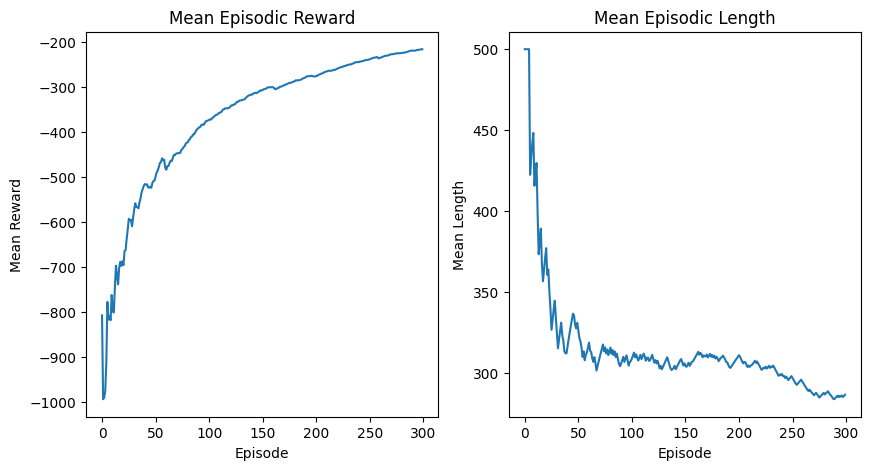

In [ ]:
plot_model_performance(mean_rewards, mean_lengths)